**Import libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

/tmp/ipykernel_25/553948091.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_25/553948091.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.library['seaborn-whitegrid']


In [2]:
# Reading data
pjme = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',index_col=[0], parse_dates=[0])

In [3]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
pjme.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


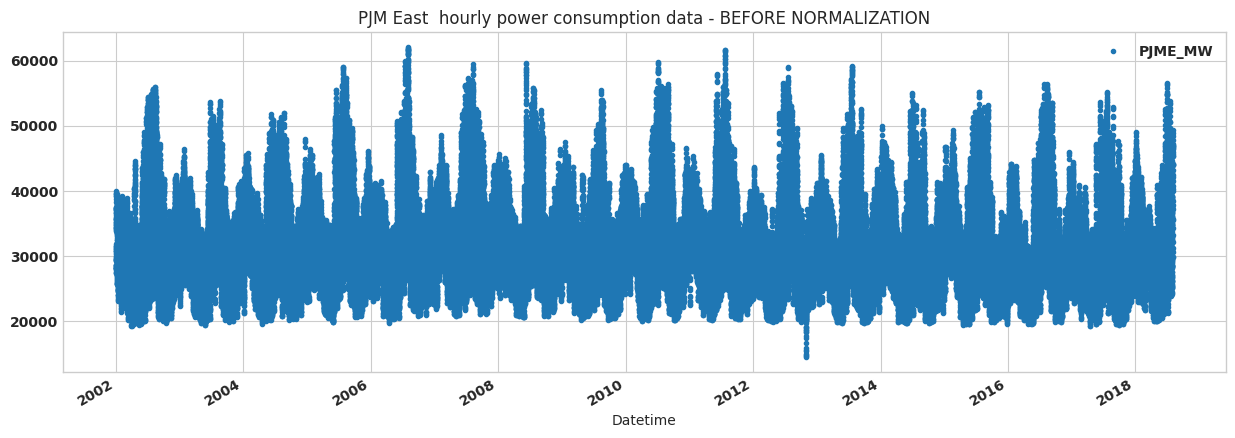

In [5]:
pjme.plot(style='.', figsize=(15,5), title='PJM East  hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [6]:
import sklearn
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

pjme = normalize_data(pjme)
pjme.shape

(145366, 1)

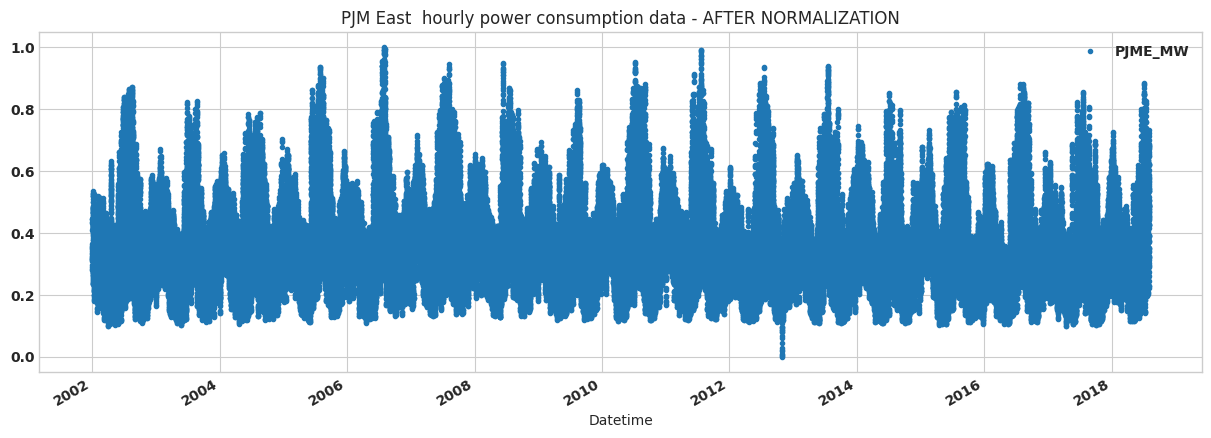

In [7]:
pjme.plot(style='.', figsize=(15,5), title='PJM East  hourly power consumption data - AFTER NORMALIZATION' )
plt.show()

**splitting data**

In [8]:
split_date = '01-Jan-2016'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

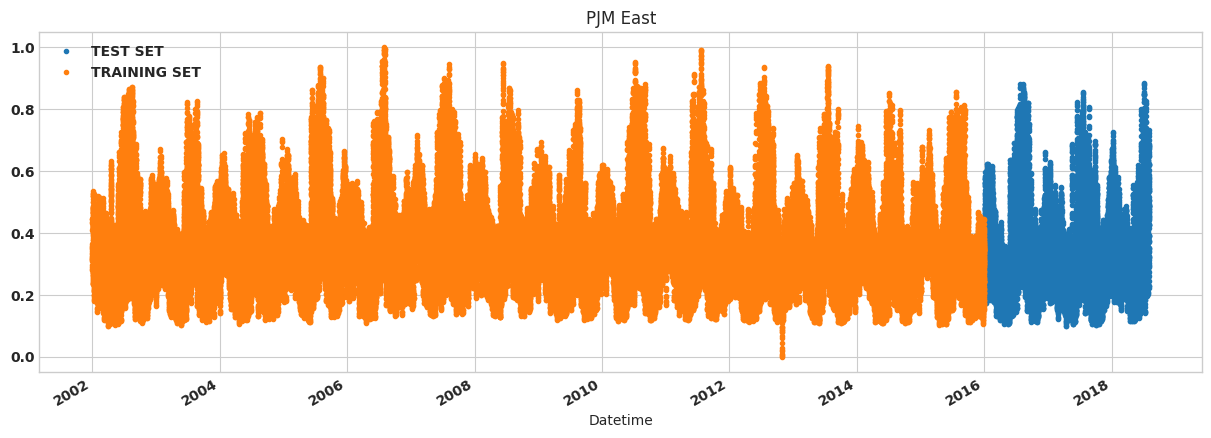

In [9]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [10]:
def load_data(train,test, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(train)):
        X_train.append(train.iloc[i-seq_len : i, 0])
        y_train.append(train.iloc[i, 0])
    
    X_test = []
    y_test = []
    for i in range(seq_len, len(test)):
        X_test.append(test.iloc[i-seq_len : i, 0])
        y_test.append(test.iloc[i, 0])
   
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (X_train.shape[0], seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [11]:
#create train, test data
seq_len = 20 

X_train, y_train, X_test, y_test = load_data(pjme_train , pjme_test , seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (122667, 20, 1)
y_train.shape =  (122667,)
X_test.shape =  (22659, 20, 1)
y_test.shape =  (22659,)


# **Building Models**

**ResNet**

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Add, Activation , Flatten
from tensorflow.keras.models import Model

# Define the residual block
def residual_block(x):
    # Define the first dense layer
    dense_0 = Dense(64, activation='relu')(x)

    # Define the second dense layer
    dense_1 = Dense(9, activation='relu')(dense_0)

    # Add the input to the output of the second dense layer (residual connection)
    add_0 = Add()([dense_1, x])

    # Define the third dense layer
    dense_2 = Dense(64, activation='relu')(add_0)

    return dense_2

# Define the input layer
inputs = tf.keras.Input(shape=(20, 1))

# Apply the residual block
residual_output = residual_block(inputs)

flat = Flatten()(residual_output)
# Define the output layer
output = Dense(1, activation='linear')(flat)

# Create the model
model = Model(inputs=inputs, outputs=output)

model.summary()

2024-06-08 17:57:42.203008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 17:57:42.203127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 17:57:42.322123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 64)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20, 9)     │        585 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 9)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 64)    │        640 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1280)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      1,281 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634 (10.29 KB)

 Trainable params: 2,634 (10.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Set the learning rate
learning_rate = 0.001

# Compile the model with the Adam optimizer and the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# Earlly Stopping
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.keras", verbose=1,
                                         save_best_only=True, monitor='val_loss',mode='min')

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32 ,validation_split = 0.1, callbacks=[callback , checkpointer])

Epoch 1/100
 113/3450 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0293

I0000 00:00:1717869475.022889      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3441/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028
Epoch 1: val_loss improved from inf to 0.00039, saving model to ./checkpoint-01.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0028 - val_loss: 3.9015e-04
Epoch 2/100
3418/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3632e-04
Epoch 2: val_loss improved from 0.00039 to 0.00037, saving model to ./checkpoint-02.keras
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.3619e-04 - val_loss: 3.6551e-04
Epoch 3/100
3415/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9752e-04
Epoch 3: val_loss did not improve from 0.00037
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.9750e-04 - val_loss: 3.6801e-04
Epoch 4/100
3448/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8594e-04
Epoch 4: val_loss did not improve from 0.00037
3450/3450 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.8594e-04 - val_loss: 3.8148e-04
Epoch 5/100
3445/3450 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8120e-04
Epoch 5: val_loss did not improve from 0

**Models Evaluation**

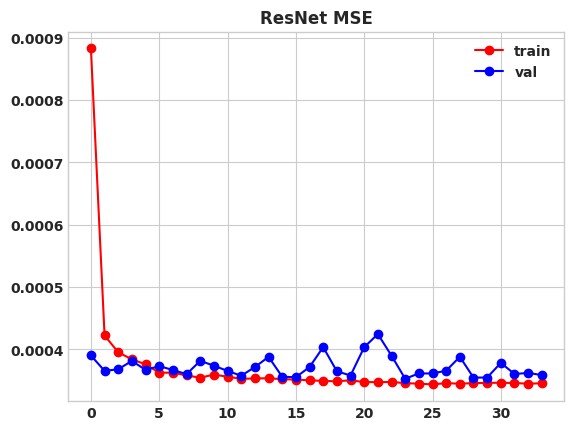

In [15]:
# plot history
plt.plot(history.history['loss'],'r-o', label='train')
plt.plot(history.history['val_loss'],'b-o', label='val')
plt.legend()
plt.title("ResNet MSE" , weight='bold')
plt.show()

In [16]:
# make a prediction
yhat_train = model.predict(X_train)

3834/3834 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [17]:
import sklearn.metrics as skm
from math import sqrt

def model_metrics(target: pd.DataFrame, predictions: []) -> None:
    print("Explained variance regression score: %.3f" %skm.explained_variance_score(target, predictions))
    print("Maximum residual error: %.3f" %skm.max_error(target, predictions))
    print("Mean squared error: %.3f" %skm.mean_squared_error(target, predictions))
    print("R2 Score: %.3f" %skm.r2_score(target, predictions))
    print("Root-mean-square Error: %.3f" %sqrt(skm.mean_squared_error(target, predictions)))
    print("Median_absolute_error: %.3f" %skm.median_absolute_error(target , predictions))
    print("Mean_absolute_error: %.3f" %skm.mean_absolute_error(target , predictions))

In [18]:
# Test Set 
yhat = model.predict(X_test)

709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [19]:
print("***  ResNet Evaluation ***** ")
model_metrics(y_test , yhat)

***  ResNet Evaluation ***** 
Explained variance regression score: 0.981
Maximum residual error: 0.246
Mean squared error: 0.000
R2 Score: 0.981
Root-mean-square Error: 0.019
Median_absolute_error: 0.009
Mean_absolute_error: 0.012


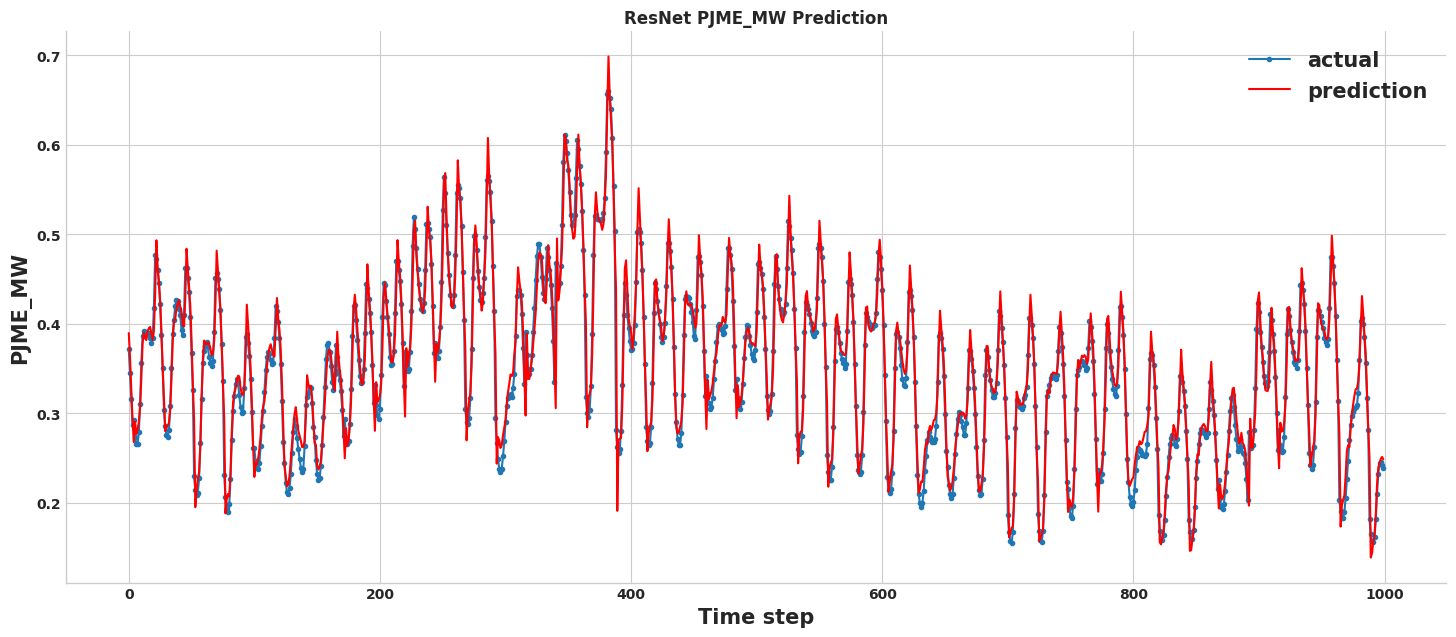

In [20]:
plt.figure(figsize=(15,6))
plt.plot( y_test[:1000], marker='.', label="actual")
plt.plot( yhat[:1000], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('PJME_MW', size=15 , weight='bold')
plt.xlabel('Time step', size=15 , weight='bold')
plt.legend(fontsize=15)
plt.title("ResNet PJME_MW Prediction" , weight='bold')
plt.show();